---
# Introduction

Unsupervised clustering algorithms group data points together based on some measure of similarity. However, once those groups are determined, what do they mean? How can we explain to our stakeholders what makes data inside a cluster similar to other data inside the cluster and different than data in other clusters?

This takes some work to analyze each cluster individually and to compare each cluster to the others. By doing this, we can find trends that we can report.


---
# Example: Country Segmentation

In this example, a non-profit would like to target countries for charitable works and projects. They would like us to target a group of countries that are most in need of these services. They have asked us to cluster the nations using the data they have provided to identify a group of countries that they should focus on. They would also like to know what kinds of issues they should address in those countries. [You can download the data here](https://docs.google.com/spreadsheets/d/e/2PACX-1vQHEke-l-EzyRY7kSMCdFnlrvD8EUa-Midhz4PxpPltYzRI7MuLEryJZndKyWgYoSVfVreM12r35OxQ/pub?gid=1079841500&single=true&output=csv)


# Load and Clean the Data

We will load, scale, and cluster the data as usual, making sure to choose the optimal number of clusters to get the countries that are most alike.

First let's examine the data dictionary provided to get a sense of what this data are about. It’s always important to understand our data before analysis.

We see that our data include economic and health related information.

Now let’s import our packages and data and see what the data frame looks like. Since each row represents a different country we can instruct pandas to set that column as the index.


In [31]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

df = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vQHEke-l-EzyRY7kSMCdFnlrvD8EUa-Midhz4PxpPltYzRI7MuLEryJZndKyWgYoSVfVreM12r35OxQ/pub?gid=1079841500&single=true&output=csv', index_col='country')


We will check that there is no missing data and no duplicated rows to make sure our data are clean.

In [32]:
print('Number of Duplicated Rows', df.duplicated().sum())
print('\n')
df.info()

Number of Duplicated Rows 0


<class 'pandas.core.frame.DataFrame'>
Index: 167 entries, Afghanistan to Zambia
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   child_mort  167 non-null    float64
 1   exports     167 non-null    float64
 2   health      167 non-null    float64
 3   imports     167 non-null    float64
 4   income      167 non-null    int64  
 5   inflation   167 non-null    float64
 6   life_expec  167 non-null    float64
 7   total_fer   167 non-null    float64
 8   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2)
memory usage: 13.0+ KB


The data look clean. Let’s also get a sense of some summary statistics.

In [33]:
df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


There are definitely some big discrepancies, but nothing that looks like an error.

# Scaling and Modeling

Scaling is always necessary before using a distance based model, and clustering is distance based. So, we will scale our data before modeling it.

In [34]:
# Scale the data
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(df), columns= df.columns)
X_scaled.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.291532,-1.138280,0.279088,-0.082455,-0.808245,0.157336,-1.619092,1.902882,-0.679180
1,-0.538949,-0.479658,-0.097016,0.070837,-0.375369,-0.312347,0.647866,-0.859973,-0.485623
2,-0.272833,-0.099122,-0.966073,-0.641762,-0.220844,0.789274,0.670423,-0.038404,-0.465376
3,2.007808,0.775381,-1.448071,-0.165315,-0.585043,1.387054,-1.179234,2.128151,-0.516268
4,-0.695634,0.160668,-0.286894,0.497568,0.101732,-0.601749,0.704258,-0.541946,-0.041817


Next let’s fit some KMeans modes with different numbers of clusters to see how many clusters are optimal.

It’s important to set a random state for KMeans models for reproducibility. They have randomized starting points for their initial centroids and we will get different results with different runs if we don’t set a random state.

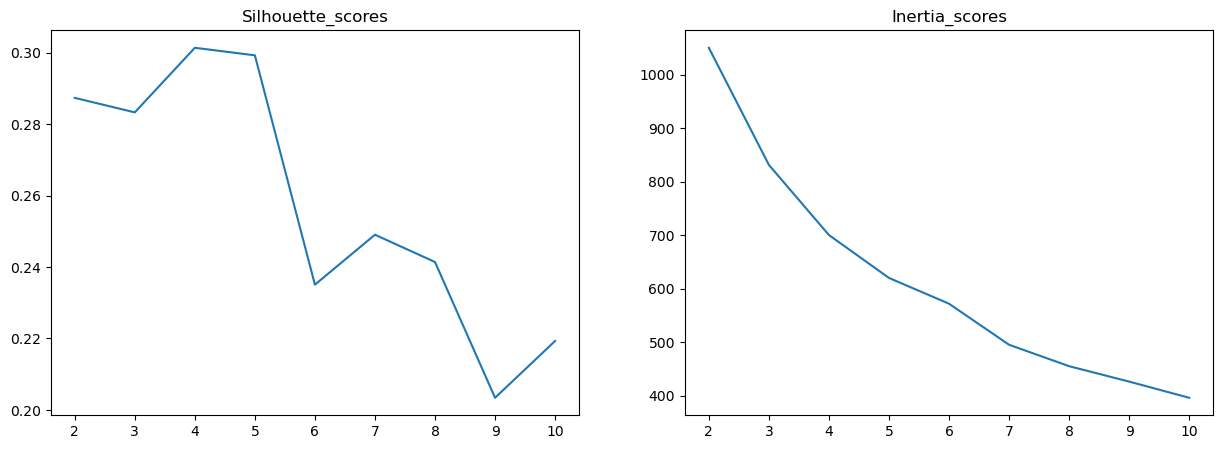

In [35]:
# Iterate over a range of k clusters to find the optimal number of clusters
ks = range(2,11)
sils = []
inertias = []
for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    sils.append(silhouette_score(X_scaled, kmeans.labels_))
    inertias.append(kmeans.inertia_)

# Plot inertias and silhouette scores for each number of clusters.
fig, axes = plt.subplots(1,2,figsize=(15,5))
axes[0].plot(ks, sils)
axes[0].set_title('Silhouette_scores')
axes[0].set_xticks(ks)
axes[1].plot(ks, inertias)
axes[1].set_title('Inertia_scores')
axes[1].set_xticks(ks)

We can see that clustering the data into 4 groups gives us the best silhouette score and we can detect an elbow in the inertia plot at 4. While the inertia plot does not have a very pronounced elbow at any number, the silhouette score does seem to favor 4 or 5 groups. We will go with 4.

Let’s fit a new model with 4 clusters and add those clusters as a new column in our original (unscaled) data frame.

In [36]:
# Refit KMeans with 4 clusters 
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X_scaled)
# Add the clusters as a column in the data frame
df['cluster'] = kmeans.labels_
df.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster
country,,,,,,,,,,
Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,1
Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,0
Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,0
Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,1
Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,0


# Analyzing the Clusters

Now that we have clustered the data we can analyze the clusters. We want to get some summary statistics about each cluster. What statistics do we want?

Mean values of each feature will be the most useful in understanding the clusters as a whole. Retrieving the maximum or minimum values might also be interesting in some cases, but a mean gives us a sense of the cluster as a whole.

We will group the data by cluster and aggregate the groups by the mean values of each feature

In [37]:
# Group the dataframe by cluster and aggregate by mean values
# Add as_index=False so that the clusters are a column, not the index
cluster_groups = df.groupby('cluster', as_index=False).mean()
cluster_groups

,cluster,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,0,21.389655,41.290678,6.235862,48.038689,12968.620690,7.413460,72.935632,2.286552,6919.103448
1,1,92.961702,29.151277,6.388511,42.323404,3942.404255,12.019681,59.187234,5.008085,1922.382979
2,2,4.953333,45.826667,9.168667,39.736667,45250.000000,2.742200,80.376667,1.795333,43333.333333
3,3,4.133333,176.000000,6.793333,156.666667,64033.333333,2.468000,81.433333,1.380000,57566.666667


The table above gives us a lot of information about each cluster, but visualizing the data can help us build an intuition about the clusters.

# Visualizing the Clusters

As data scientists we deal a lot in numbers, but plotting values is great for comparison and important for presentations. Now that we have our data clustered and the mean values of each feature calculated, Pandas and Matplotlib make it fairly straightforward to plot our data.

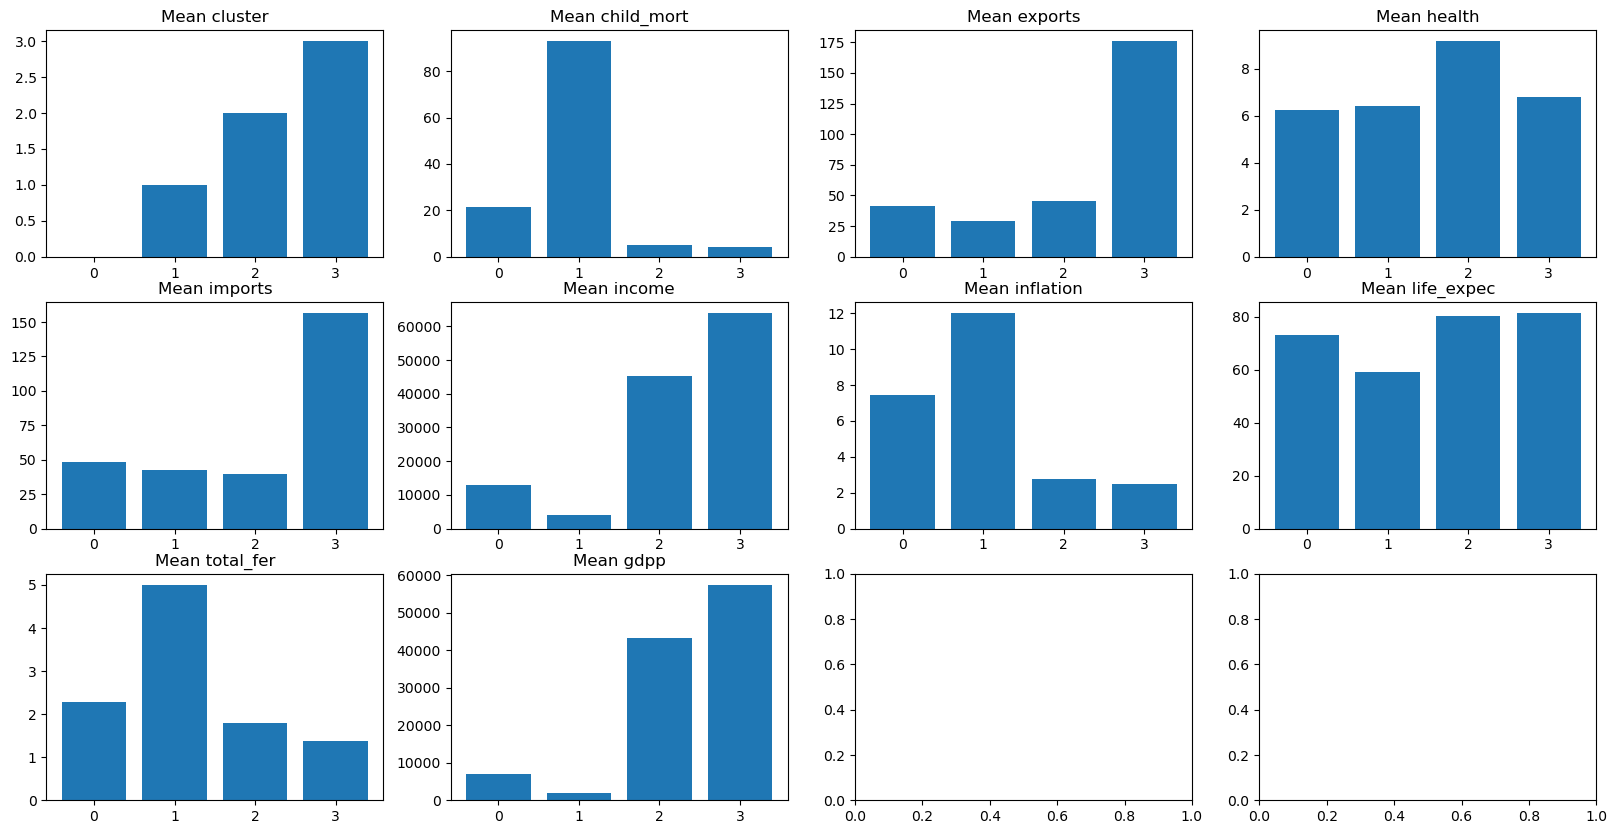

In [38]:
# Visualize means
fig, axes = plt.subplots(3,4, figsize=(20,10))
# fig is an array of dimensions 3,4. axes.ravel() will flatten it to 12,1
axes = axes.ravel()
# Loop over columns and plot each in a separate figure, skip 'cluster' column
for i, col in enumerate(cluster_groups[1:]):
    axes[i].bar(cluster_groups['cluster'], cluster_groups[col])
    axes[i].set_title(f'Mean {col}')
    

Cluster 0 has a high child mortality rate, but also a significantly higher average income than cluster 1. Life expectancy is closer to clusters 2 and 3, but still significantly lower. Clusters 0 and 1 are similar, but nations in cluster 0 seem to tend to be a little more developed and may have some industrialization or natural resources to trade to other nations. Cluster 0 has similar exports to Cluster 2, Despite a lower average income and GDP per person. In addition to cluster 1, these nations may also be good candidates for charitable activities by the stakeholders. They do seem to be in a slightly better position, however.

## Cluster 1:
Cluster 1 has the highest child mortality rate, least exports, lowest average income, highest inflation, lowest life expectancy, highest fertility rate and lowest GDP per person. While their exports are much lower than the other clusters, their imports rates are similar to clusters 0 and 2. This may mean that they are dependent on foreign goods, but do not produce a lot of goods for export. The populations in these nations tend to be desperately impoverished and unhealthy. This cluster might be a good candidate for our stakeholder’s efforts.

## Cluster 2:
Cluster 2 nations have considerably lower imports and exports than cluster 3, but are similar in child mortality and inflation rates, both being low. While individuals in these nations have somewhat lower incomes than cluster 3 and the GDP per person is lower, they seem to be healthier. These nations seem to be more self-sufficient, less dependent on foreign trade, but have generally healthy and comfortable populations. These would not be candidates for charitable activities.

## Cluster 3:
Cluster 3 has the lowest child mortality rate, the most exports and imports, the highest income, least inflation, highest life expectancy, lowest fertility rate, and highest GDP per person. From what we know of the world we might expect these to be first world, industrialized nations that are deeply involved in international trade. These would not be good candidates for charitable activities by the stakeholders.

# Filtering the Data Frame by Cluster
We now have a selection of charts visually showing the comparisons between each cluster for each of the features. In our presentation we can choose a few of them to highlight in order to make the case that the countries in cluster 1 are the ones our stakeholders should focus on. Let’s take a quick look at which countries those are. Remember that we set the country names to the index of our data frame, so that is what we will print out.

In [39]:
df.loc[df['cluster']==1].index

Index(['Afghanistan', 'Angola', 'Benin', 'Botswana', 'Burkina Faso', 'Burundi',
       'Cameroon', 'Central African Republic', 'Chad', 'Comoros',
       'Congo, Dem. Rep.', 'Congo, Rep.', 'Cote d'Ivoire', 'Equatorial Guinea',
       'Eritrea', 'Gabon', 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau',
       'Haiti', 'Iraq', 'Kenya', 'Kiribati', 'Lao', 'Lesotho', 'Liberia',
       'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Mozambique', 'Namibia',
       'Niger', 'Nigeria', 'Pakistan', 'Rwanda', 'Senegal', 'Sierra Leone',
       'South Africa', 'Sudan', 'Tanzania', 'Timor-Leste', 'Togo', 'Uganda',
       'Yemen', 'Zambia'],
      dtype='object', name='country')